In [ ]:
### ------>>>>> 1
##################### Good starting point########################
import torch
import numpy as np
import pandas as pd
import pandas as pd 
import torch.nn as nn
import pandas_ta as ta
import matplotlib.pyplot as plt
from ichimoku import plt_candle,add_plot, cal_ich

# df=pd.read_csv('./ETH-USD.csv')
# df=cal_ich('./ETH-USD.csv')
# fig,ax=plt.subplots(1,figsize=(10,5))
# ich_value=df[['chikou_span','kijun_sen','tenkan_sen']]
# chikou_value=ich_value['chikou_span']

df=cal_ich('./eth_save.csv',period=18)

import yfinance as yf
"""   Valid periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max \n,
            Valid intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo 
"""

df=yf.download(tickers='btc-usd',start='2023-02-13',end='2023-02-20',interval='30m',)
df.to_csv('eth_save.csv',)

fig,ax=plt.subplots(figsize=(20,10))
# ax=fig.add_subplot(1,1,1)
plt_candle('./eth_save.csv',ax=ax,full=True,period=18)
df=cal_ich('./eth_save.csv',period=18)
period=18


In [ ]:
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from scipy.stats import linregress
from  ichimoku import plt_candle

 
class Chart_pattern:
    def __init__(self,data):
        self.data=data
        self.result={"two_pairs":[],
                        "cross_high":[],
                        "cross_low":[],
                        "three_pair":[],
                        "duplicated_high":[],
                        "duplicated_low":[],
                        "Draw_line":[],
                        "check_time_enter":[],
                        "EnterPrice":[],
                        "postion_inf": [],
                        "fake_signal":[]
                        }
        
        self.swing_low=[]
        self.swing_high=[]
        self.two_pairs=[]
        
        self.duplicate_low=[]
        self.duplicate_high=[]
        
        self.cross_high=[]
        self.cross_low=[]

        self.two_pair()
        
        
        
    global fig
    fig=plt.figure(figsize=(25  ,7))
    global ax
    ax=fig.add_subplot(1,1,1)

    def time_eval(self):
        
        # check if our datetime fromat is hourly
        if  self.data.index[2] - self.data.index[1] ==datetime.timedelta(hours=1):
            time_st_40=datetime.timedelta(hours=40)
            time_st_30=datetime.timedelta(hours=30)
            
            status_interval='hour'


        elif  self.data.index[2] - self.data.index[1] ==datetime.timedelta(days=1):
            time_st_40=datetime.timedelta(days=40)
            time_st_30=datetime.timedelta(days=30)
            
            status_interval='day'

            
        else:
            # df.index[2] - df.index[1] ==datetime.timedelta(   minutes=30):
            time_st_40=datetime.timedelta(minutes=1200)
            # 25 candle validity
            time_st_30=datetime.timedelta(minutes=750)

            status_interval='minute'

        return time_st_40, time_st_30, status_interval


    def check_size(self):
        price_a= np.array(self.result['two_pairs'])[-1,0,0]
        price_b=np.array(self.result['two_pairs'])[-1,1,0]

        price_change_trend= ( (price_b - price_a) / price_a)* 100
        return  round(price_change_trend, 2)    


    def finding_cross(self):

        status_t= False
        status_chik= False

        #################### Finding chikou_t Crosses #########################        
        self.data['base_line']=ta.trend.ichimoku_base_line(high=self.data.High,low=self.data.Low,window1=26, window2=26)
        self.data['convertion_line']=ta.trend.ichimoku_conversion_line(high=self.data.High,low=self.data.Low,window1=9, window2=9)
        self.data['chikou_span']=self.data.Close.shift(-30)

        for xi,(chik,t) in enumerate(zip(self.data['chikou_span'],self.data['convertion_line'])):
                    
            # finding tenkan_sen -> corssing from below

            if t >  chik  and  status_t==False:
                self.result['cross_high'].append([t,self.data['chikou_span'].index[xi] ])

                # cross_below_date.append(ich_time[i])
                status_t=True

            elif t < chik : # kijun_sen cross the t in top
                status_t=False
            

            if chik >  t  and  status_chik==False: # we have Cross in bottom
                self.result['cross_low'].append([ chik,self.data['chikou_span'].index[xi] ])
                
                # cross_high_time.append(ich_time[i])
                status_chik=True

            elif t > chik : # tenkan_sen cross the k in bottom
                status_chik=False

        #################### Finding Crosses #########################   


    def two_pair(self):

        low_status=False
        high_status=False
        # intialting the finding cross function 
        self.finding_cross()

        time_st_40,time_st_30,_=self.time_eval()
        print(f'{_} Timeframe data as input')
                
        for i in range(len(self.data)):
            
            # Maximum Price in 5 period of candle
            # C=df.Close.iloc[i:i+5].groupby(np.arange(len(df.Close.iloc[i:i+5 ])) // 5).max()
            

            # Price chekcer for find the best swing,
            """
                By default we choose to investigate the 10 candle to finding the best swing in each period.
                but also we can decrease this period to 5 and it's optional to increase to more than 10 candle.

            """
            counter= 1
            high_price,high_index=self.data.Close.iloc[i: i+ counter].max(),self.data.Close.iloc[i:i+ counter].idxmax()
            Low_price,low_index=self.data.Close.iloc[i: i+ counter].min(),self.data.Close.iloc[i:i+ counter].idxmin()
            
            # maximum price in 40/30 candle before
            validity,third_candl=self.data.Close.loc[ high_index - time_st_40 :high_index], self.data.Close.loc[high_index : high_index + time_st_30 ]

            
            
            if high_index - time_st_40   < self.data.index[0]:
                continue
            
            # High swing
            if (high_price > validity).sum() ==40  and   (high_price > third_candl ).sum() == 25:
            
                # we have updated low_siwng
                if high_status == True and low_status == False:
                    print('duplicated  high')
                    # Replace the new swing to prevous one
                    self.result['duplicated_high'].append(self.swing_high[-1] )
                    self.swing_high.pop()
                    self.swing_high.append( [ high_price,high_index] )
                    
                else:
                    self.swing_high.append([ high_price,high_index])
                    high_status= True

            # Low swing
            if (Low_price < validity).sum() ==40  and   (Low_price < validity ).sum() ==40:
                

                if low_status  == True and high_status == False:
                    
                    # Replace the new swing to prevous one
                    self.result['duplicated_low'].append(self.swing_low[-1])
                    self.swing_low.pop()
                    self.swing_low.append([self.data.Low[low_index],low_index])


                else:
                    self.swing_low.append([self.data.Low[low_index],low_index])
                    low_status=True


            if  low_status == True and high_status == True:
                if self.swing_high[-1][1] < self.swing_low[-1][1]:
                    continue

            # Founding the two pair
            if low_status == True and high_status == True:

                # reset the status
                low_status,high_status = False,False

                print('we have found valid two pair...')
                self.result['two_pairs'].append([self.swing_low[-1],self.swing_high[-1]] )

                # print(self.check_size(), '%')
                self.draw_trend()


            # # trend is too small, we can ignore it
            # if  self.check_size() < 3:
            #     print('high risk Detection, the Trend is too small')

            #     # adding small trend to fake_signal
            #     self.result['fake_signal'].append(result['two_pairs'][-1])
            #     # delete the small trend from valid two pair
            #     self.result['two_pairs'].pop(-1)
            #     continu
        

    def draw_trend(self,first=None,last=None):
        # crosses of chikou

        _,_,status_interval=self.time_eval()

        if status_interval == 'day':
            Daily_shifted=datetime.timedelta(days=30)

        elif status_interval == 'hour':
            Daily_shifted=datetime.timedelta(hours=50)

        else:
            # 50  candle waiting for enter
            Daily_shifted=datetime.timedelta(minutes=1500)

            
        # Last two valid pair of swing in the Chart
        two_pairs=self.result['two_pairs'][-1]


        first_time=two_pairs[0][1]
        #  index of 40 candles after high pivot 
        last_time=two_pairs[1][1] + Daily_shifted

        if last== None:
            last_time = last_time
        else:
            # we are above the line and we are maek sure that we wound't have any other cross line after the first one
            last_time = last

        crosses=pd.Series(data=np.array(self.result['cross_high'])[:,0],index=np.array(self.result['cross_high'])[:,1]).loc[first_time:last_time]

        try:

            cross_last_price,cross_last_date=crosses[-1],crosses.index[-1]
            
            last_time_raw= two_pairs[1][1]


            #  index of 30 candles after high pivot 
            last_time_2= last_time_raw +  datetime.timedelta(minutes=750) 


            # cross_std=np.std(crosses)            
            # if len(crosses) == 0:
            #     print('we found no crosses in high swing')

            line_date= pd.date_range(two_pairs[0][1],cross_last_date + Daily_shifted,freq='30min')
            line_price= np.linspace(two_pairs[0][0],cross_last_price  ,num=len(line_date) )
                
            ################################### optimze the lower Drawing line ##########################################
            # first we find all the negetive vlaue
            candle_tracker=[( self.data.Low[self.data.index == xx] - yy ,xx)  for yy,xx in zip(line_price,line_date)]


            # negetive_under_curve_idx= np.argmax((np.array(candle_tracker)[:,0]))

            # optimizer= candle_tracker[negetive_under_curve_idx][0]
                
            num_extended_line=100
            x_ext = np.linspace(0, num_extended_line,num_extended_line)
            x=np.arange(len(line_date))
            price_y=np.poly1d(( np.polyfit(x, line_price , deg=1)))(x_ext)

            date_x= pd.date_range(two_pairs[0][1],freq='30min',periods= num_extended_line)

            self.result['Draw_line'].append(
                                        [  price_y,
                                        date_x] )
            # print('drawing is complete')
            self.result['check_time_enter'].append([self.data.High[self.data.index ==last_time_2][0] ,last_time_2  ])

            self.Find_Enter()
                

        except: print('not succeed in finding any lines in the two pivot')

    def Find_Enter(self):
        
        # check time enter from 25 candle after  than high switong
        price,date=self.result['check_time_enter'][-1][0],self.result['check_time_enter'][-1][1]

        """"
            one of the key factor to make sure our line was optimzed we check another time to the all candles above the line
            senarios:
                1. if the price after 30 counting was above the line:
                    -> we double check the crosses in the high to make sure our line woud get optimze by drawing again with the new crosses
                2. if the price after 30 counting was below the line:
                    -> if this is happen we ingore the signal and put them into fake signal 
                
        """
        
        
        # high_checker=self.data.High.loc[date:]

        
        price_tracker= self.data.High.loc[date:]
        # pivot high price
        pivot_price= np.array(self.result['two_pairs'])[-1,1,0]
        
        # Tracking high price with the drawing line        
        for j,(yprice,indexi) in enumerate(zip(self.data.High.loc[date:],price_tracker.index  )):

            # 
            ## -> draw_line lsit would be dity
            # self.draw_trend(np.array(self.result['two_pairs'])[-1,1,1],indexi)

            line=pd.Series(data=self.result['Draw_line'][-1][0], index=self.result['Draw_line'][-1][1])
            try:
                
                line.loc[indexi]

            except: 
                print('index eror in draw_line')
                break

            # 1. Check if the price woudn't be higher that the last high pivot
            # 2. check if the Enter wouldn't be lower than the half of the two_pair


            # We are above the line
            half_pair=self.result['two_pairs'][-1][1][0]  - self.result['two_pairs'][-1][0][0]
            fake_status = False
            
            if yprice > pivot_price or (pivot_price- yprice) < half_pair:
                print('This singal is Fake')
                self.result['fake_signal'].append(self.result['two_pairs'][-1])

                fake_status=True
                break

            


            # The price break the support line -> valid singal
            if  (yprice -  line.loc[indexi])  < 0 :
                print('we are are above the line')
                self.result['EnterPrice'].append( [yprice, indexi  ])
                
                print('we found enterpoint')

            # saving result into ax.plot
                self.plot_result()    
                break



        """
            4. ignore the signal if the entery point is near to the swing_low --->>> solved
            2. optimze the drawing line ---->>> solved
            3. ignore the singal if the price goes up the high swing --->>> Solved

            5. ignore the singal that the enter are less than the half of the whole trend(two_pairs) --->>> not solved
            1. show conver from below --->>> not solve
            
            
        """
        # except: print('Eror')
            
                # Setting stop sl/tp
                # if len (self.result['EnterPrice'][-1]) != 0:
                #     first_sl=np.array(self.result['two_pairs'])[i,1,0]
                #     first_tp=( np.array(self.result['two_pairs'])[i,0,0] + price ) /2
                #     second_tp= ( np.array(self.result['two_pairs'])[i,0,0] + first_tp)/2

                #     # postive tp devided by negetive sl
                #     risk_reward_first_tp= ((yprice - first_tp) / first_tp) /  ((np.array(self.result['two_pairs'])[i,1,0]  - yprice) / yprice)
                #     risk_reward_second_tp= ((yprice - second_tp) / second_tp) /   ((np.array(self.result['two_pairs'])[i,1,0]  - yprice) / yprice)
                #     self.result['postion_inf'].append([first_sl,first_tp,second_tp,risk_reward_first_tp,risk_reward_second_tp])

                

        # we are below the line
        # else:
        #     print('we found the fake singal')

                # if  len(self.result['Draw_line'][-1]) !=0
                        
                    # self.result['fake_signal'].append(self.result['Draw_line'][])
                    # self.result['Draw_line'].pop(-1)


    def plot_result(self):
        
        alpha= self.data.Close.std() - 0.04
    
        alpha_1= self.data.Close.std() /2

        plt_candle(data=self.data,ax=ax,period=18,path_data=False,full=True,ich=False)
        # ax.set_xlim(xmin=self.data.index[0], xmax=self.data.index[-1]+ datetime.timedelta(hours=50))


        ax.scatter(np.array(self.result['two_pairs'])[-1,0,1],np.array(self.result['two_pairs'])[-1,0,0] - alpha_1,c='green',marker='^',label='swing_low')
        ax.scatter(np.array(self.result['two_pairs'])[-1,1,1],np.array(self.result['two_pairs'])[-1,1,0]  +  alpha_1,c='red',marker='v',label='swing_high')
        plt.close()

        font = {
            'weight' : 'bold',
                'size'   : 10}

        # Enter candle
        # plt.vlines(x=np.array(result['EnterPrice'])[:,0] , ymax=np.array(result['EnterPrice'])[:,1]+ alpha, ymin=np.array(result['EnterPrice'])[:,1],
        #                                 linewidth=2 ,color='red')   

        # Lines
        Draw_line=self.result['Draw_line'][-1]
        ax.plot(Draw_line[1],Draw_line[0],label='valid_signal',c='black')

        # for i in result['fake_signal']:
        #     plt.plot(i[1],i[0],label='fake_signal',c='red')

        
        if   len(self.result['EnterPrice'])  != 0:
            enter_date,enter_price=self.result['EnterPrice'][-1][1],self.result['EnterPrice'][-1][0]

            ax.annotate(text=f'enter',xy=( enter_date,enter_price) ,xytext=( enter_date,enter_price  + 0.00000005),arrowprops=dict(arrowstyle= '<|-|>',
                                    color='blue',
                                    lw=1.25,
                                    ls='-'),**font,
                                    clip_on=True)
            # ax.scatter(enter_date,enter_price,marker='^',color='black')    
        
        # i=result['postion_inf'][-1]
        # sl_price=i[0]
        # tp_price=i[1]
        # tp2_price=i[2]
        # r1=i[3]
        # r2=i[-1]

        # ax.annotate(text='Enter',xy=(enter_date,enter_price - alpha*alpha) ,arrowprops=dict(arrowstyle= '<|-|>',
        #                         color='blue',
        #                         lw=1,
        #                         ls='-'),**font,xytext=(enter_date,  enter_price + alpha*2),label='Enter')
                            
        # First sl
        # ax.hlines(y=sl_price,xmin=date_refrence,xmax=date_refrence + time_extend,
        #                     color='#990000', linestyle='solid',linewidth=2)
        # plt.annotate(text=f'Sl -> {sl_price :.2f}',xy=(date_refrence + time_extend_inf , sl_price) ,**font)

        # # First tp
        # ax.hlines(y=tp_price,xmin=date_refrence,xmax=date_refrence + time_extend,
        #                     color='green', linestyle='dashed')
        # plt.annotate(text=f'tp_1 -> {tp_price :.2f}',xy=(date_refrence + time_extend_inf , tp_price) ,**font)

        # # Second tp
        # ax.hlines(y=tp2_price,xmin=date_refrence,xmax=date_refrence + time_extend,
        #                     color='green', linestyle='solid',)

        # plt.annotate(text=f'tp_2 -> {tp2_price :.2f}',xy=(date_refrence + time_extend_inf , tp2_price), **font)

        # # Enter point
        # ax.hlines(y=enter_price,xmin=date_refrence,xmax=date_refrence + time_extend,
        #                     color='#D8D056', linestyle='solid',label='Enter')

        # plt.annotate(text=f'Enter point -> {enter_price :.2f}',xy=(date_refrence + time_extend_inf , enter_price), **font)


        # ax.set_title(loc='Center',label='Test',font=font)
        # # ax.gca().set_title('title')
        # ax.legend(loc='best',prop={'size':10})

        # # plt.savefig('plotting.jpeg')
        ax.scatter(np.array(self.result['check_time_enter'])[-1,1],np.array(self.result['check_time_enter'])[-1,0]  ,marker='*',linewidth=2)
        ax.tick_params(axis="x", labelsize=10)

        # get the value of the xaxis
        len_x=len(self.result['Draw_line'][-1][1])

        



        # plt.xlim(len(result['Draw_line'][-1][1])[0],self.result['Draw_line'][-1][1])
        



        #   ax.plot(data['convertion_line'])
                
        #   ax.plot(data['chikou_span'])
        return fig

# import yfinance as yf

# data=yf.download('sol-usd',start='2023-04-07',end=datetime.datetime.today(),interval='30m')
data=crypto_api(start='2023-03-29',end='2023-04-03')

obj=Chart_pattern(data)
data=obj.data
result=obj.result
obj.plot_result()

'"\n how do we update the swing that are close to each other\n\n\n # ---->>> Three pairs swings <<<------, Sell signal\n if we have a low swing with 40_candle seperation, and two swing that the first one is:\n        1. first swing_high ->\n                            40 candle seperation from left----- 20 candle sepration from right\n        2. second swing_high -> \n                            20 candle sepration from left ----- 20 candle seperaiton from right,\n\n        3. first swing_low --->\n                            40 candle sepratio from the left -----40 candle sepration from the right\n\n\n        Enter---->>>\n                    we count from the the second high_swing  and trend the line from the swing_low chikou_span  to the last cross in the high.\n                    the crosses must be exist and would created after the formation of he second high_swing.\n\n        ERRoR--->>>\n                if we found no crosses  after the second high_swing which is (20 candle per

In [164]:
import requests
import json
import pandas as pd
def crypto_api():
    # api_key='BCB6D5AE-CA02-40F2-B38B-E371250E967C'
    api_key='F482043C-CE3B-47AE-8952-3F1DAEC2843A'
             
    url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/latest?period_id=30MIN&limit=1000&time_start=2023-03-25&time_end=2023-03-25'


    headers = {'X-CoinAPI-Key' : api_key}
    response =( requests.get(url, headers=headers)).json()

    with open('jsondata.json', 'w') as f:
        json.dump(response, f)

    json_1=pd.read_json("jsondata.json")

    df=json_1
    df.index=pd.to_datetime(df['time_period_start'])
    df=df.iloc[:,4:-1]
    df=df.rename({'price_open': 'Open', 'price_high': 'High','price_low':'Low','price_close':'Close','volume_traded':'Volume'}, axis='columns')

    # Data need to be sorted
    # df=data.sort_index()
    return df.sort_index()

data=crypto_api()
# data.index=data.index.rename('index',inplace=True)
# data.index=pd.to_datetime(data.index)


In [ ]:
"""
    we build the sell class stategies,
    to_do list:
    1. working with vectorbt backtesting
    2. build buy class stategies, maybe i merge them together
    3. Celery and automation
    4. what about learning algorithm
    5. well tuning with forex market
    6. i'm mising the ai part in


"""

In [124]:
import yfinance as yf
import datetime
# data=yf.download('eth-usd',start='2023-04-01',end=datetime.datetime.today())
Z=yf.download("shib-usd",period="1mo",interval="30m")

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Datetime'>

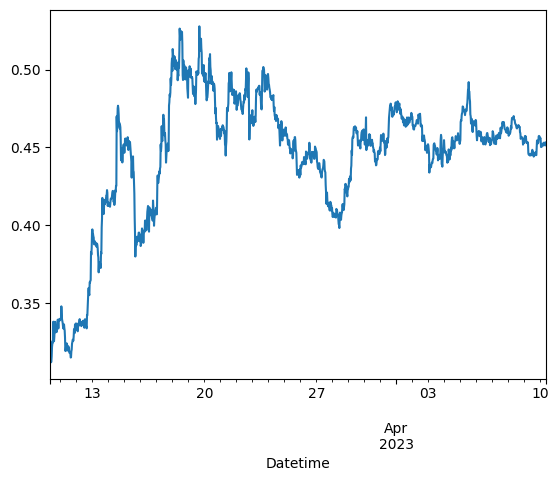

In [62]:
Z.Close.plot()


In [ ]:
# price = vbt.Portfolio.from_holding(df, init_cash=100)
fast_ma = vbt.MA.run(df.Close, 5)
slow_ma = vbt.MA.run(df.Close, 25)

# entries = fast_ma.ma_crossed_above(slow_ma)
# exits = fast_ma.ma_crossed_below(slow_ma)


enter=df.Close < 21990.597656
exit=df.Close  > 28023.103516

# pf_kwargs = dict(size=0.10, fees=0.001) #**pf_kwargs
pf = vbt.Portfolio.from_signals(close=df.Close,
                            #     sl_stop=1500,
                                short_entries=enter,
                                short_exits=exit,
                                       init_cash=20)

pf.total_profit()
# showing hte stats of the full trade
# pf.stats()
pf.plot().show()

In [ ]:
pf.stats()

Start                         2023-03-08 12:00:00
End                           2023-04-08 11:30:00
Period                           31 days 00:00:00
Start Value                                  20.0
End Value                               25.572668
Total Return [%]                        27.863341
Benchmark Return [%]                    26.965632
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        11.121597
Max Drawdown Duration            11 days 01:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                           0.042131
Win Rate [%]                                100.0
Best Trade [%]                          27.652684
Worst Trade [%]                         27.652684
Avg Winning Trade [%]                   27.652684
Avg Losing Trade [%]                          NaN


In [ ]:
import chart_pattern as cp

btc = yf.download('btc-usd',period='1y',interval='1h' )

# df.to_csv('btc.csv')
# btc=pd.read_csv('./btc.csv',parse_dates=True,index_col=0)
# btc
# # df.index=pd.to_datetime(df.index)


# df=pd.read_csv('/Algorithm_Trading_01/train/cryptoh/AVAX.csv',)



[*********************100%***********************]  1 of 1 completed
hour Timeframe data as input


KeyboardInterrupt: 

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# plt_candle(data=btc,ax=ax,period=30,full=True,ich=False)
btc = yf.download('btc-usd',start=pd.to_datetime('2023-01-25'),end=pd.to_datetime('2023-02-25'),interval='1h' )



[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: No data found for this date range, symbol may be delisted


[*********************100%***********************]  1 of 1 completed
minute Timeframe data as input


NameError: name 'start' is not defined

In [160]:
import yfinance as yf

kargs={
       
        }
import datetime
import matplotlib.pyplot as plt

Low_price=yf.download('btc-usd',**kargs,start='2023-03-25',end=datetime.datetime.today(),interval='30m')


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: No data found for this date range, symbol may be delisted


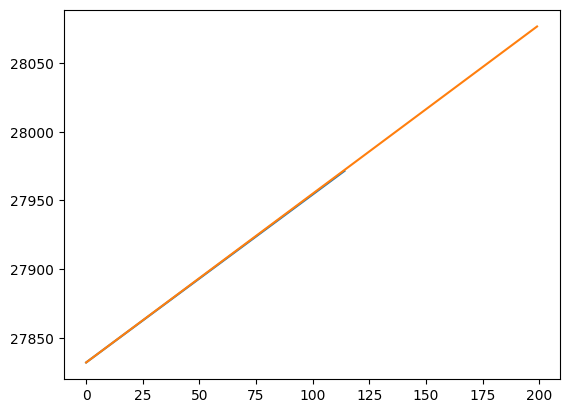

In [211]:

price=result['Draw_line'][-1][0]
date=result['Draw_line'][-1][1]
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(date)), price)



x=np.arange(len(date))

x_ext = np.linspace(0,200, 200 )

price_y=np.poly1d(( np.polyfit(x, price , deg=1)))(x_ext)

plt.plot(price)
plt.plot(price_y)

# plt.plot(price)
# plt.axline(xy1=(0, 1), slope=-0.5, color='r')
